# Project

**Description:**

This notebook provides a prediction for the [Abalone Regression competition](https://www.kaggle.com/competitions/playground-series-s4e4).

This iteration introduces clustering.

### Imports

In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib
import scipy
import scipy.stats as stats
import sklearn

print(f"Pandas version {pd.__version__}")

print(f"Numpy version {np.__version__}")

print(f"Scipy version {scipy.__version__}")

print(f"Scikit-learn version {sklearn.__version__}")

print(f"Matplotlib version {matplotlib.__version__}")


# Common Model Algorithms
from sklearn import linear_model, svm, naive_bayes, ensemble, gaussian_process, neighbors, tree, decomposition, cluster, discriminant_analysis
import xgboost as xgb
import lightgbm as lgbm
import catboost as catboost

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8


Pandas version 2.2.0
Numpy version 1.26.4
Scipy version 1.12.0
Scikit-learn version 1.4.1.post1
Matplotlib version 3.8.3


## Data preparation

In [2]:
# Import data in training, testing and validation sets
location_dataset = "data/train.csv"
location_dataset_val = "data/test.csv"

data_raw = pd.read_csv(location_dataset)
data_val_raw = pd.read_csv(location_dataset_val)

# We copy the data and package it to pass by reference
data1 = data_raw.copy(deep=True)
data_val = data_val_raw.copy(deep=True)

# Preview data
display(data_raw.info())
display(data_raw.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


None

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
66190,66190,M,0.705,0.545,0.180,1.6395,0.6470,0.3735,0.3865,11
47126,47126,F,0.600,0.450,0.170,0.9315,0.2925,0.2175,0.3100,12
49967,49967,F,0.580,0.470,0.145,0.9885,0.3895,0.1685,0.2950,10
32616,32616,I,0.330,0.280,0.085,0.1795,0.0835,0.0355,0.0600,6
70729,70729,I,0.180,0.125,0.035,0.0265,0.0095,0.0065,0.0095,4
47370,47370,I,0.345,0.255,0.095,0.1990,0.0695,0.0450,0.0600,6
21778,21778,I,0.515,0.400,0.125,0.5235,0.2135,0.1270,0.1790,8
30013,30013,F,0.575,0.450,0.150,1.1755,0.4115,0.2025,0.2700,14
60542,60542,F,0.510,0.390,0.125,0.5965,0.2435,0.1235,0.2000,10
61614,61614,I,0.350,0.265,0.090,0.1990,0.0730,0.0435,0.0600,7


### Cleaning

**Next steps**: 4 C's of data cleaning:
- Correcting (fix aberrant values)
- Completing (impute missing values using a predefined methodology which can be improved/complexified in later iterations)
- Creating (create new features if they can provide new signal)
- Converting (choose an encoding for categorical and date or currency formats)

In [3]:
print("Train columns with null values:\n", data1.isnull().sum())
print("-" * 10)

print("Test/Validation columns with null values:\n", data_val.isnull().sum())
print("-" * 10)

data_raw.describe(include="all")

Train columns with null values:
 id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64
----------
Test/Validation columns with null values:
 id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64
----------


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,33093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,45307.000000,NaN,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,NaN,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,NaN,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,NaN,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,NaN,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,NaN,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000


There are no missing values so this will make the cleanup easier.

In [4]:
#### CORRECTING

# Usually nothing to do on Kaggle datasets which are rather clean

In [5]:
#### COMPLETING

# Nothing to do in this case


# Delete the cabin feature as well as the possibly unique identifiers
drop_columns = ["id"]
for dataset in [data1, data_val]:
    dataset.drop(drop_columns, axis=1, inplace=True)

print(data1.isnull().sum())
print("-" * 10)
print(data_val.isnull().sum())

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64
----------
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64


In [6]:
# Useful helper functions for the converting step

def onehot_encode(label, train, test, oh_encoder):
    # convert
    train_col = train[label].to_numpy().reshape(-1, 1)
    test_col = test[label].to_numpy().reshape(-1, 1)
    # fit
    oh_encoder.fit(train_col)
    # transform
    train_col_oh = oh_encoder.transform(train_col)
    test_col_oh = oh_encoder.transform(test_col)
    # rename
    train_col_oh.columns = oh_encoder.get_feature_names_out([label])
    test_col_oh.columns = oh_encoder.get_feature_names_out([label])
    # concatenate
    return pd.concat([train, train_col_oh], axis=1), pd.concat([test, test_col_oh], axis=1)

def ordinal_encode(label, train, test, od_encoder):
    # convert
    train_col = train[label].to_numpy().reshape(-1, 1)
    test_col = test[label].to_numpy().reshape(-1, 1)
    # fit
    od_encoder.fit(train_col)
    # transform
    train_col_od = od_encoder.transform(train_col)
    test_col_od = od_encoder.transform(test_col)
    # rename
    train_col_od.columns = [label + "_Code"]
    test_col_od.columns = [label + "_Code"]
    # concatenate
    return pd.concat([train, train_col_od], axis=1), pd.concat([test, test_col_od], axis=1)

def minmax_scale(label, train, test, minmax_scaler):
    # convert
    train_col = train[label].to_numpy().reshape(-1, 1)
    test_col = test[label].to_numpy().reshape(-1, 1)
    # fit
    minmax_scaler.fit(train_col)
    # transform
    train_col_minmax = minmax_scaler.transform(train_col)
    test_col_minmax = minmax_scaler.transform(test_col)
    # rename
    train_col_minmax.columns = [label + "_MinMaxScaled"]
    test_col_minmax.columns = [label + "_MinMaxScaled"]
    # concatenate
    return pd.concat([train, train_col_minmax], axis=1), pd.concat([test, test_col_minmax], axis=1)

def std_scale(label, train, test, std_scaler):
    # convert
    train_col = train[label].to_numpy().reshape(-1, 1)
    test_col = test[label].to_numpy().reshape(-1, 1)
    # fit
    std_scaler.fit(train_col)
    # transform
    train_col_std = std_scaler.transform(train_col)
    test_col_std = std_scaler.transform(test_col)
    # rename
    train_col_std.columns = [label + "_StdScaled"]
    test_col_std.columns = [label + "_StdScaled"]
    # concatenate
    return pd.concat([train, train_col_std], axis=1), pd.concat([test, test_col_std], axis=1)

def code_data(train, test, encoders, features):
    # Label encoding
    for label in features["ordinal"]:
        train, test = ordinal_encode(label, train, test, encoders["ordinal"])

    # One-hot encoding
    for label in features["onehot"]:
        train, test = onehot_encode(label, train, test, encoders["onehot"])
    
    # Minmax scaler
    for label in features["minmax"]:
        train, test = minmax_scale(label, train, test, encoders["minmax"])
        
    # Std scaler
    for label in features["std"]:
        train, test = std_scale(label, train, test, encoders["std"])
        
    return train, test


In [7]:
#### CONVERTING

# A crucial step here is to avoid leakage between the test and training sets. So various encoders should be fit on the training data only.

label_features = ["Sex"]
oh_features = ["Sex"]
standard_scale_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1','Whole weight.2', 'Shell weight']
minmax_scale_features = []

# Label and one-hot encoding
od_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
oh_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
oh_encoder.set_output(transform="pandas")
od_encoder.set_output(transform="pandas")

# Scalers
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()
minmax_scaler.set_output(transform="pandas")
std_scaler.set_output(transform="pandas")

# We combine all these into objects for easier generalization
encoders_obj = {"ordinal": od_encoder, "onehot": oh_encoder, "minmax": minmax_scaler, "std": std_scaler}
features_obj = {
    "ordinal": label_features,
    "onehot": oh_features,
    "minmax": minmax_scale_features,
    "std": standard_scale_features,
}

# Apply the scaling and encoding
data1, data_val1 = code_data(data1, data_val, encoders_obj, features_obj)

# Target
target = ["Rings"]

# Define X features for comparison
features_original = [
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Whole weight.1",
    "Whole weight.2",
    "Shell weight",
    "Sex",
]
features_original_coded = [
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Whole weight.1",
    "Whole weight.2",
    "Shell weight",
    "Sex_Code",
]
features_original_coded_scaled = [
    "Length_StdScaled",
    "Diameter_StdScaled",
    "Height_StdScaled",
    "Whole weight_StdScaled",
    "Whole weight.1_StdScaled",
    "Whole weight.2_StdScaled",
    "Shell weight_StdScaled",
    "Sex_Code",
]
features_and_target_original = features_original + target

print("Original X Y: ", features_and_target_original, "\n")

features_dummy = [
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Whole weight.1",
    "Whole weight.2",
    "Shell weight",
    "Sex_F",
    "Sex_I",
    "Sex_M"
]
features_and_target_dummy = features_dummy + target

print("Dummy X Y: ", features_and_target_dummy, "\n")

Original X Y:  ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Sex', 'Rings'] 

Dummy X Y:  ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M', 'Rings'] 



In [8]:
#### CREATING

# We create a clustering feature
kmeans = cluster.KMeans(n_clusters=6, n_init=10, random_state=0)
data1["Cluster"] = kmeans.fit_predict(data1[features_original_coded_scaled])
data_val1["Cluster"] = kmeans.predict(data_val1[features_original_coded_scaled])

# Add the new feature to the list of features
features_original_coded += ["Cluster"]
features_original_coded_scaled += ["Cluster"]
features_dummy += ["Cluster"]

# preview data again
data1.info()
data_val.info()
data1.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Sex                       90615 non-null  object 
 1   Length                    90615 non-null  float64
 2   Diameter                  90615 non-null  float64
 3   Height                    90615 non-null  float64
 4   Whole weight              90615 non-null  float64
 5   Whole weight.1            90615 non-null  float64
 6   Whole weight.2            90615 non-null  float64
 7   Shell weight              90615 non-null  float64
 8   Rings                     90615 non-null  int64  
 9   Sex_Code                  90615 non-null  float64
 10  Sex_F                     90615 non-null  float64
 11  Sex_I                     90615 non-null  float64
 12  Sex_M                     90615 non-null  float64
 13  Length_StdScaled          90615 non-null  float64
 14  Diamet

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_Code,...,Sex_I,Sex_M,Length_StdScaled,Diameter_StdScaled,Height_StdScaled,Whole weight_StdScaled,Whole weight.1_StdScaled,Whole weight.2_StdScaled,Shell weight_StdScaled,Cluster
82347,I,0.505,0.395,0.120,0.6385,0.3050,0.1215,0.1405,8,1.0,...,1.0,0.0,-0.102342,-0.068137,-0.406870,-0.328917,-0.175016,-0.474905,-0.655884,0
66527,I,0.275,0.200,0.065,0.0875,0.0345,0.0225,0.0280,5,1.0,...,1.0,0.0,-2.047932,-2.057409,-1.853959,-1.532846,-1.498225,-1.455993,-1.519922,4
47581,M,0.655,0.525,0.185,1.5820,0.6935,0.3180,0.3650,13,2.0,...,0.0,1.0,1.166522,1.258045,1.303325,1.732620,1.725414,1.472407,1.068351,2
21185,M,0.500,0.385,0.125,0.6355,0.2635,0.1065,0.1500,10,2.0,...,0.0,1.0,-0.144637,-0.170151,-0.275317,-0.335472,-0.378022,-0.623555,-0.582921,0
30238,I,0.395,0.300,0.115,0.3200,0.1575,0.0925,0.0990,7,1.0,...,1.0,0.0,-1.032841,-1.037270,-0.538424,-1.024836,-0.896544,-0.762294,-0.974618,1
13807,F,0.545,0.430,0.140,0.8020,0.3595,0.1845,0.2250,9,0.0,...,0.0,0.0,0.236022,0.288912,0.119344,0.028328,0.091582,0.149424,-0.006896,5
59474,M,0.550,0.435,0.130,0.7905,0.3475,0.1765,0.2250,9,2.0,...,0.0,1.0,0.278317,0.339919,-0.143763,0.003201,0.032882,0.070144,-0.006896,3
71421,I,0.430,0.325,0.075,0.3315,0.1885,0.0550,0.1060,7,1.0,...,1.0,0.0,-0.736773,-0.782235,-1.590852,-0.999709,-0.744901,-1.133919,-0.920856,1
38536,M,0.415,0.310,0.120,0.3215,0.1500,0.0570,0.0950,7,2.0,...,0.0,1.0,-0.863660,-0.935256,-0.406870,-1.021559,-0.933232,-1.114099,-1.005340,1
37915,F,0.600,0.475,0.175,1.1745,0.4250,0.2375,0.4250,21,0.0,...,0.0,0.0,0.701272,0.747975,1.040218,0.842237,0.411989,0.674653,1.529172,5


### Train/test split

We split the data into training and testing sets. We do this for all three types of encoding

In [9]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[features_original_coded], data1[target], test_size=0.3, random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1[features_dummy], data1[target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x.head()

Data1 Shape: (90615, 21)
Train1 Shape: (63430, 9)
Test1 Shape: (27185, 9)


,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Sex_Code,Cluster
37629,0.620,0.485,0.200,1.2255,0.5405,0.2960,0.360,2.0,3
60382,0.595,0.470,0.165,0.9910,0.4565,0.2270,0.276,1.0,3
65068,0.410,0.305,0.115,0.3350,0.1410,0.0735,0.090,1.0,1
77789,0.575,0.450,0.170,0.9550,0.4135,0.2095,0.230,0.0,5
43495,0.500,0.385,0.120,0.6675,0.3175,0.1235,0.180,1.0,0


## EDA

Now that the data is clean, we can analyze its statistics and the value distribution to understand this dataset.

In [11]:
# We start with the survival correlation for each feature
def print_target_correlation(df, feature, target):
    print('Target Correlation by:', feature)
    print(data1[[feature, target]].groupby(feature, as_index=False).mean())
    print('-'*10, '\n')

for x in features_original:
    if data1[x].dtype != 'float64' :
        print_target_correlation(data1, x, target[0])
        
print(pd.crosstab(data1['Sex'],data1[target[0]]))

Target Correlation by: Sex
  Sex      Rings
0   F  11.161389
1   I   7.533557
2   M  10.753408
---------- 

Rings  1   2    3     4     5     6     7     8     9     10  ...   19   20  \
Sex                                                           ...             
F       7   2    1     0    17   127   546  2381  5936  5038  ...  311  248   
I      13  21  342  1317  2703  4995  7463  8514  4336  1465  ...   28   18   
M       5   6   43    85   142   289   999  3604  7193  5961  ...  300  241   

Rings   21  22  23  24  25  26  27  29  
Sex                                     
F      136  61  97  11  10   7  17  12  
I       11   5   8   0   0   1   1   2  
M      108  42  75  18  12  10  23  10  

[3 rows x 28 columns]


In [21]:
# Then we do distribution plots

# def make_figure_distribution(df, features, target):
#     fig, axs = plt.subplots(ncols=len(features), nrows=2, figsize=[16,12])
#     for i in range(len(features)):
#         feature = features[i]
#         sns.boxplot(df, x=target, y = feature, ax=axs[0, i], medianprops={'ls': ':', 'lw': 3})
#         sns.boxplot(df, y = feature, ax=axs[0, i], medianprops={'ls': ':', 'lw': 3})
#         sns.histplot(df, x=feature, hue=target, ax=axs[1,i])
# make_figure_distribution(data1, ["Length", "Whole weight"], target[0])

In [22]:
# Next we do multivariable comparison

# def make_figure_multilabels(df, target, features):
#     fig, axs = plt.subplots(ncols=len(features), nrows=1, figsize=[16,6])
#     for i in range(len(features)):
#         feature = features[i]
#         sns.barplot(df, y=target, x = feature, hue=feature, ax=axs[i])
        
# def make_figure_bins(df, target, features):
#     fig, axs = plt.subplots(ncols=len(features), nrows=1, figsize=[16,6])
#     for i in range(len(features)):
#         feature = features[i]
#         sns.pointplot(df, y=target, x = feature, ax=axs[i])
        
# make_figure_multilabels(data1, target[0], ["Embarked", "Pclass", "IsAlone"])
# make_figure_bins(data1, target[0], ["FareBin", "AgeBin", "FamilySize"])

In [23]:
# Now we compare qualitative class with numerical ones

# def make_figure_compare_qual_num(df, feature1, features, target):
#     fig, axs = plt.subplots(ncols=len(features), nrows=1, figsize=[16,6])
#     for i in range(len(features)):
#         feature = features[i]
#         sns.boxplot(df, y=feature, x = feature1, hue=target, ax=axs[i], medianprops={'ls': ':', 'lw': 3})
        
# def make_figure_compare_qual_qual(df, feature1, features, target):
#     fig, axs = plt.subplots(ncols=len(features), nrows=1, figsize=[16,6])
#     for i in range(len(features)):
#         feature = features[i]
#         sns.barplot(df, y=target, x = feature1, hue=feature, ax=axs[i])

# make_figure_compare_qual_qual(data1, "Sex", ["Embarked", "Pclass", "IsAlone"], target[0])

# make_figure_compare_qual_num(data1, "Pclass", ["Fare", "Age", "FamilySize"], target[0])

In [24]:
# We can also do 3-fold comparisons
# def make_threefold_comparison(df, row_feature,  col_feature, target):
#     h = sns.FacetGrid(df, row = row_feature, col = col_feature, hue = target)
#     h.map(plt.hist, "Age", alpha = 0.75)
#     h.add_legend()
    
# make_threefold_comparison(data1, "Sex", "Pclass", target[0])
    

In [12]:
# Very useful -- pair plots of the entire dataset
def make_pair_plot(df, target):
    pp = sns.pairplot(df, hue = target, palette = 'deep', height=1.2, diag_kind = 'kde', diag_kws=dict(fill=True), plot_kws=dict(s=10) )
    pp.set(xticklabels=[])
    
# make_pair_plot(data1[features_original_coded + target], target[0])

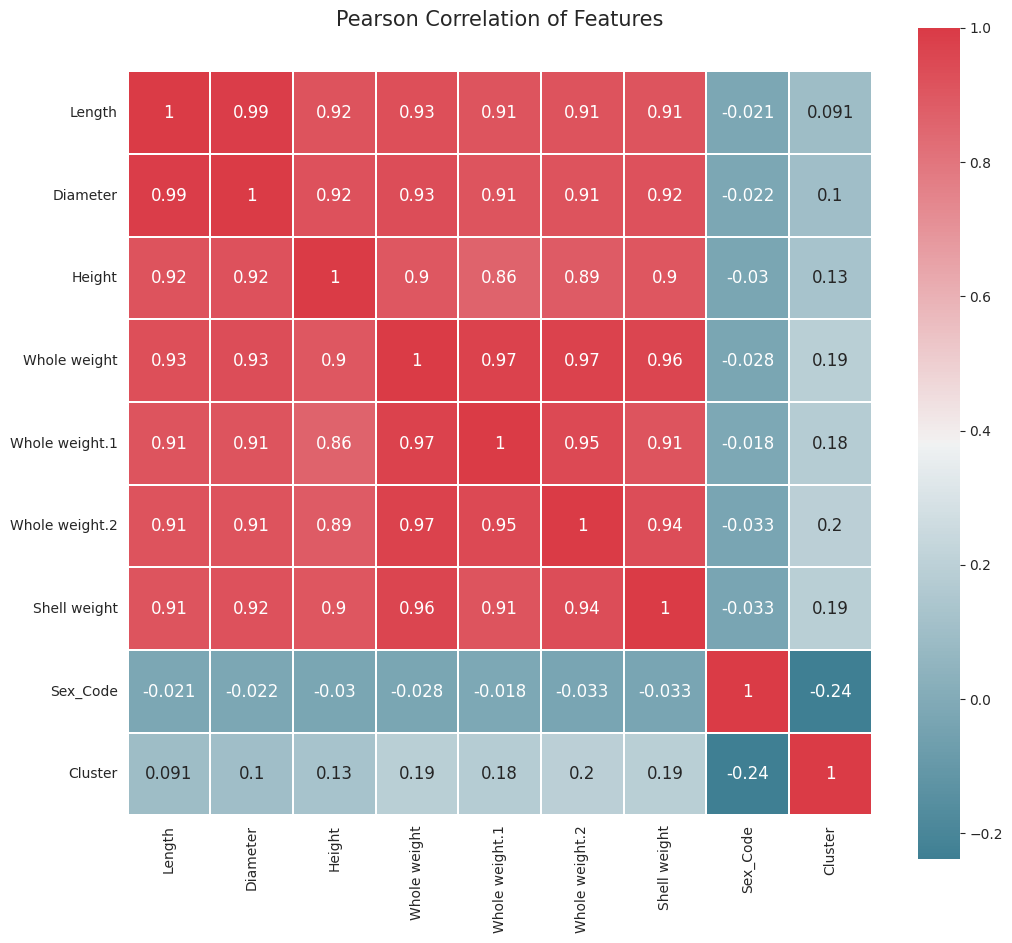

In [13]:
#correlation heatmap of dataset
def correlation_heatmap(df, figsize=(12,12)):
    _ , ax = plt.subplots(figsize = figsize)
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1[features_original_coded])



## Model data

In this section, we define various ML models and compare them

In [10]:
# Cross-test split the data (10 samples, 30% test, 60% train, 10% left out)
cv_split = model_selection.ShuffleSplit(n_splits = 3, test_size = .3, train_size = .6, random_state = 0)

In [11]:
def create_comparison_alg():
    MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
    return pd.DataFrame(columns = MLA_columns)
# Handy function to test a given ML algorithm
def run_alg_cv(alg, X, y, cv):
    MLA_compare = create_comparison_alg()
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print(f"Evaluating algorithm {MLA_name}")
    MLA_compare.loc[0, 'MLA Name'] = MLA_name
    MLA_compare.loc[0, 'MLA Parameters'] = str(alg.get_params())
    
    # Test the algorithm on the cross-validation dataset
    cv_results = model_selection.cross_validate(alg, X, y, cv  = cv, return_train_score=True, scoring="neg_root_mean_squared_log_error")
    # Store results
    MLA_compare.loc[0, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[0, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[0, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[0, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    # Keep a copy of the predictions
    alg.fit(X, y)
    MLA_predict = pd.DataFrame(alg.predict(X), index=y.index, columns=[MLA_name])
    
    return MLA_compare, MLA_predict

# Applies the previous helper function to a list of algorithms
def run_all_algs(list_alg, X, y, cv):
    output_per_alg = [run_alg_cv(alg, X, y, cv) for alg in list_alg]
    MLA_compare = pd.concat([out1 for out1,out2 in output_per_alg], axis=0)
    MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
    MLA_compare = MLA_compare.reset_index().drop("index", axis=1)
    
    y_compare = pd.concat([y] + [out2 for out1, out2 in output_per_alg], axis=1)
    
    return MLA_compare, y_compare
    
    
    

In [12]:
# Define various models
MLA = [
    # Ensemble methods
    # ensemble.AdaBoostRegressor(),
    # ensemble.BaggingRegressor(),
    # ensemble.ExtraTreesRegressor(),
    # ensemble.GradientBoostingRegressor(),
    # ensemble.RandomForestRegressor(),
    
    # Gaussian process
    # gaussian_process.GaussianProcessRegressor(),
    
    # Linear model
    linear_model.LinearRegression(),
    #linear_model.LogisticRegression(max_iter=2_000),
    linear_model.Lasso(),
    linear_model.ElasticNet(),
    linear_model.SGDRegressor(),
    
    # Naive Bayes
    naive_bayes.MultinomialNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbor
    neighbors.KNeighborsRegressor(),
    
    #SVM
    # svm.SVR(kernel="rbf"),
    
    #Trees    
    # tree.DecisionTreeRegressor(),
    # tree.ExtraTreeRegressor(),

    #Cluster
    # cluster.MeanShift(),
    cluster.MiniBatchKMeans(),
    cluster.KMeans(),
    
    xgb.XGBRegressor(eval_metric="rmsle"),
    # lgbm.LGBMRegressor(),
    # catboost.CatBoostRegressor(),
]

MLA_compare, y_compare = run_all_algs(MLA, data1[features_original_coded], data1[target], cv_split)

Evaluating algorithm LinearRegression


/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, 

Evaluating algorithm Lasso
Evaluating algorithm ElasticNet
Evaluating algorithm SGDRegressor


/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site

Evaluating algorithm MultinomialNB


/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed w

Evaluating algorithm GaussianNB


/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nchagnet/pyenvs/kaggle_py/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed w

Evaluating algorithm KNeighborsRegressor
Evaluating algorithm MiniBatchKMeans
Evaluating algorithm KMeans
Evaluating algorithm XGBRegressor


In [13]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",-0.133796,-0.152662,0.00139,0.89498
1,KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.133098,-0.165383,0.001072,0.11882
2,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",-0.216196,-0.217277,0.001157,0.050398
3,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",-0.264115,-0.265631,0.005433,0.112863
4,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",-0.272603,-0.273963,0.004068,0.067053
5,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",-0.288055,-0.289348,0.004059,0.067673
6,KMeans,"{'algorithm': 'lloyd', 'copy_x': True, 'init':...",-1.230304,-1.23421,0.259139,0.168767
7,MiniBatchKMeans,"{'batch_size': 1024, 'compute_labels': True, '...",-1.333201,-1.33255,0.169982,0.134688
8,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",NaN,NaN,NaN,0.031862
9,SGDRegressor,"{'alpha': 0.0001, 'average': False, 'early_sto...",NaN,NaN,NaN,0.851144


Here is the part where we take a step back and think critically about these results. First we need to compare this to baseline accuracy given by the survival rate (how wrong would we be if we guessed everyone survived or everyone died).

All the previous models outperform this basic strategy which is reassuring.

In [14]:
# Compare all predictions of the different algorithms together
correlation_heatmap(y_compare, figsize=(16,16))

NameError: name 'correlation_heatmap' is not defined

## Model tuning

We will choose one of the top scoring models and tune its hyperparameters.

#### Hyperparameters

In [15]:
def tune_model_hyperparameters(X, y, cv, model_ref, param_grid, scoring="accuracy"):
    # Define the model
    model = model_ref(random_state=0)
    base_results = model_selection.cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=scoring)
    model.fit(X, y)

    print("BEFORE model Parameters: ", model.get_params())
    print("BEFORE model Training score mean: {:.5f}".format(base_results["train_score"].mean()))
    print("BEFORE model Test score mean: {:.5f}".format(base_results["test_score"].mean()))
    print("BEFORE model Test score 3*std: +/- {:.5f}".format(base_results["test_score"].std() * 3))
    print("-" * 10)

    # Define a parameter grid
    param_grid["random_state"] = [0]

    tune_model = model_selection.GridSearchCV(
        model_ref(), param_grid=param_grid, cv=cv, return_train_score=True, scoring=scoring
    )
    tune_model.fit(X, y)
    print("AFTER model Parameters: ", tune_model.best_params_)
    # print(tune_model.cv_results_['mean_train_score'])
    print(
        "AFTER model Training score mean: {:.5f}".format(
            tune_model.cv_results_["mean_train_score"][tune_model.best_index_]
        )
    )
    # print(tune_model.cv_results_['mean_test_score'])
    print(
        "AFTER model Test score mean: {:.5f}".format(
            tune_model.cv_results_["mean_test_score"][tune_model.best_index_]
        )
    )
    print(
        "AFTER model Test score 3*std: +/- {:.5f}".format(
            tune_model.cv_results_["std_test_score"][tune_model.best_index_] * 3
        )
    )
    print("-" * 10)
    return tune_model

In [16]:
# Define a parameter grid
param_grid = {
    "eval_metric": ["rmsle"],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.25],
    "n_estimators": [10, 50, 100, 300],
    "max_depth": [1, 2, 4, 6, 8, 10],
}

result_tuning_hyperparameters = tune_model_hyperparameters(
    data1[features_original_coded], data1[target], cv_split, xgb.XGBRegressor, param_grid, scoring="neg_root_mean_squared_log_error"
)

BEFORE model Parameters:  {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 0, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
BEFORE model Training score mean: -0.13380
BEFORE model Test score mean: -0.

#### Feature selection

In [17]:
def tune_model_rfe_hyperparameters(X, y, cv, model_ref, param_grid, scoring="accuracy"):
    # Define the model
    model = model_ref(random_state=0)
    base_results = model_selection.cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=scoring)
    model.fit(X, y)
    
    #base model
    print('BEFORE model RFE Training Shape Old: ', X.shape) 
    print('BEFORE model RFE Training Columns Old: ', X.columns.values)

    print("BEFORE model RFE Training score mean: {:.5f}". format(base_results['train_score'].mean())) 
    print("BEFORE model RFE Test score mean: {:.5f}". format(base_results['test_score'].mean()))
    print("BEFORE model RFE Test score 3*std: +/- {:.5f}". format(base_results['test_score'].std()*3))
    print('-'*10)

    #feature selection
    model_rfe = feature_selection.RFECV(model, step = 1, scoring = scoring, cv = cv)
    model_rfe.fit(X, y)

    #transform x&y to reduced features and fit new model
    features_rfe = list(X.columns[model_rfe.get_support()])
    X_rfe = X[features_rfe]
    rfe_results = model_selection.cross_validate(model, X, y, cv  = cv, return_train_score=True, scoring=scoring)

    #print(dtree_rfe.grid_scores_)
    print('AFTER model RFE Training Shape New: ', X_rfe.shape) 
    print('AFTER model RFE Training Columns New: ', features_rfe)

    print("AFTER model RFE Training score mean: {:.5f}". format(rfe_results['train_score'].mean())) 
    print("AFTER model RFE Test score mean: {:.5f}". format(rfe_results['test_score'].mean()))
    print("AFTER model RFE Test score 3*std: +/- {:.5f}". format(rfe_results['test_score'].std()*3))
    print('-'*10)

    #tune rfe model
    param_grid["random_state"] = [0]
    rfe_tune_model = model_selection.GridSearchCV(model_ref(), param_grid=param_grid, scoring = scoring, cv = cv, return_train_score=True)
    rfe_tune_model.fit(X_rfe, y)

    #print(rfe_tune_model.cv_results_.keys())
    #print(rfe_tune_model.cv_results_['params'])
    print('AFTER model RFE Tuned Parameters: ', rfe_tune_model.best_params_)
    #print(rfe_tune_model.cv_results_['mean_train_score'])
    print("AFTER model RFE Tuned Training score mean: {:.5f}". format(rfe_tune_model.cv_results_['mean_train_score'][rfe_tune_model.best_index_])) 
    #print(rfe_tune_model.cv_results_['mean_test_score'])
    print("AFTER model RFE Tuned Test score mean: {:.5f}". format(rfe_tune_model.cv_results_['mean_test_score'][rfe_tune_model.best_index_]))
    print("AFTER model RFE Tuned Test score 3*std: +/- {:.5f}". format(rfe_tune_model.cv_results_['std_test_score'][rfe_tune_model.best_index_]*3))
    print('-'*10)


    return rfe_tune_model, features_rfe

In [18]:
# Define a parameter grid
param_grid = {
    "eval_metric": ["rmsle"],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.25],
    "n_estimators": [10, 50, 100, 300, 400],
    "max_depth": [1, 2, 4, 6, 8, 10],
    "objective": ["reg:squaredlogerror"]
}

result_tuning_rfe_hyperparameters, features_rfe = tune_model_rfe_hyperparameters(
    data1[features_original_coded],
    data1[target],
    cv_split,
    xgb.XGBRegressor,
    param_grid,
    scoring="neg_root_mean_squared_log_error",
)

BEFORE model RFE Training Shape Old:  (90615, 9)
BEFORE model RFE Training Columns Old:  ['Length' 'Diameter' 'Height' 'Whole weight' 'Whole weight.1'
 'Whole weight.2' 'Shell weight' 'Sex_Code' 'Cluster']
BEFORE model RFE Training score mean: -0.13380
BEFORE model RFE Test score mean: -0.15266
BEFORE model RFE Test score 3*std: +/- 0.00139
----------
AFTER model RFE Training Shape New:  (90615, 9)
AFTER model RFE Training Columns New:  ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Sex_Code', 'Cluster']
AFTER model RFE Training score mean: -0.13380
AFTER model RFE Test score mean: -0.15266
AFTER model RFE Test score 3*std: +/- 0.00139
----------
AFTER model RFE Tuned Parameters:  {'eval_metric': 'rmsle', 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 400, 'objective': 'reg:squaredlogerror', 'random_state': 0}
AFTER model RFE Tuned Training score mean: -0.14116
AFTER model RFE Tuned Test score mean: -0.15029
AFTER model RFE 

## Validation

After choosing an algorithm and tuning it, we can evaluate it on the test dataset and submit it.

In [23]:
data_val1["Rings"] = result_tuning_rfe_hyperparameters.predict(data_val1[features_rfe]).round().astype(int)

In [24]:
data_val1["Rings"]

0        10
1        10
2        10
3        10
4         8
         ..
60406     6
60407     9
60408    12
60409    14
60410     8
Name: Rings, Length: 60411, dtype: int64

In [25]:
submit = pd.concat([data_val_raw['id'], data_val1['Rings']], axis=1)
submit.to_csv("submissions/submit_iteration_3.csv", index=False)

This gets a score of 0.15104 on Kaggle!